In this notebook we show how to run a simple deep learning model to classify whale calls. We use the [keras](https://keras.io/) library. We will use a convolutional neural networks, since they are robust to temporal and spatial shifts. Although it is common to use 2D convolutional model on the spectrogram, we will use a 1D on the time series, as this can be applied to other time series classification problems. But instead of raw data, we will use Welch-filtered signals.

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# importing multiple visualization libraries
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import pylab as pl
#import seaborn

In [4]:
# importing libraries to manipulate the data files
import os
from glob import glob

In [5]:
# import a library to read the .aiff format
import aifc

In [6]:
filenames = glob(os.path.join('whale_data_train_only','train','*.aiff'))

In [7]:
from scipy import signal

In [8]:
# read signals and apply the welch filter
feature_dict = {}
fs = 2000
for filename in filenames[:10000]:
    aiff = aifc.open(filename,'r')
    whale_strSig = aiff.readframes(aiff.getnframes())
    whale_array = np.fromstring(whale_strSig, np.short).byteswap()
    # apply welch filter
    feature = 10*np.log10(signal.welch(whale_array, fs=fs, window='hanning', nperseg=256, noverlap=128+64)[1])
    feature_dict[filename] = feature

In [9]:
import pandas as pd
X = pd.DataFrame(feature_dict).T

In [10]:
# Deep learning on time domain samples.
from __future__ import division
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard

ModuleNotFoundError: No module named 'keras'

In [11]:
conda install keras

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.10
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - keras


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _tflow_select-2.3.0        |              mkl           2 KB  defaults
    absl-py-0.7.1              |           py37_0         154 KB  conda-forge
    astor-0.7.1                |             py_0          22 KB  conda-forge
    binutils_impl_linux-64-2.31.1|       h6176602_1         3.9 MB  defaults
    binutils_linux-64-2.31.1   |       h6176602_8         148 KB  defaults
    c-ares-1.15.0              |    h516909a_1001         100 KB  conda-forge
    gast-0.2.2                 |             py_0          10 KB  conda-forge
    gcc_im

In [33]:
#y = np.array(labels['label'][X.columns])
y = np.load('y.npy')
y = y.astype('float32')

In [34]:
from sklearn.model_selection import train_test_split
target_names = ['Upcall', 'NO_Upcall']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2018)

# Convert label to onehot
#y_train = keras.utils.to_categorical(y_train, num_classes=2)
#y_test = keras.utils.to_categorical(y_test, num_classes=2)

print(X_train.shape)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

(8000, 129)


In [35]:
# Build the Neural Network
model = Sequential()

model.add(Conv1D(16, 3, activation='relu', input_shape=(129, 1)))
model.add(Conv1D(16, 3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(32, 3, activation='relu'))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(256, 3, activation='relu'))
model.add(Conv1D(256, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())

model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])




model_name = 'deep_1'
top_weights_path = 'model_' + str(model_name) + '.h5'

callbacks_list = [ModelCheckpoint(top_weights_path, monitor = 'val_acc', verbose = 1, save_best_only = True, save_weights_only = True), 
    EarlyStopping(monitor = 'val_acc', patience = 6, verbose = 1),
    ReduceLROnPlateau(monitor = 'val_acc', factor = 0.1, patience = 3, verbose = 1),
    CSVLogger('model_' + str(model_name) + '.log')]

W0812 20:23:55.708056 140131228374848 deprecation_wrapper.py:119] From /srv/conda/envs/notebook/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 20:23:55.730655 140131228374848 deprecation_wrapper.py:119] From /srv/conda/envs/notebook/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 20:23:55.736019 140131228374848 deprecation_wrapper.py:119] From /srv/conda/envs/notebook/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 20:23:55.860471 140131228374848 deprecation_wrapper.py:119] From /srv/conda/envs/notebook/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.p

We see a lot of jargon:

|Term| Explanation|
|---|---|
|Convolutional Layers | layers which are robust to time shifts|
|Max Pooling/ Average Pooling |dimension reduction, robustness|
|Batch normalization |equalizes the distribution of the batches |
|Epochs |1 run of a batch |
|Adam Optimizer | an adaptive optimization scheme|
|Cross Entropy | cost function|
|ReLU | nonlinear activation function| 
|Batch Size| size of subset to process to update the estimates|
|Learning Rate | time step of the optimization algorithm|

In [36]:
#from keras.utils import plot_model
#plot_model(model,to_file='model_plot.png')

<img src="img/model_plot.png" width=200/>

In [37]:
%%time
# Fitting the Model (this will take a loooooooot of time)
model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data = [X_test, y_test], callbacks = callbacks_list)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 31s 4ms/step - loss: 0.6523 - acc: 0.6371 - val_loss: 0.5754 - val_acc: 0.7165

Epoch 00001: val_acc improved from -inf to 0.71650, saving model to model_deep_1.h5
Epoch 2/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.5594 - acc: 0.7085 - val_loss: 0.4852 - val_acc: 0.7370

Epoch 00002: val_acc improved from 0.71650 to 0.73700, saving model to model_deep_1.h5
Epoch 3/100
8000/8000 [==============================] - 24s 3ms/step - loss: 0.4886 - acc: 0.7626 - val_loss: 0.4457 - val_acc: 0.8015

Epoch 00003: val_acc improved from 0.73700 to 0.80150, saving model to model_deep_1.h5
Epoch 4/100
8000/8000 [==============================] - 24s 3ms/step - loss: 0.4445 - acc: 0.7971 - val_loss: 0.4313 - val_acc: 0.8110

Epoch 00004: val_acc improved from 0.80150 to 0.81100, saving model to model_deep_1.h5
Epoch 5/100
8000/8000 [==============================] - 22

#### Evaluation

In [38]:
model.load_weights(top_weights_path)
loss, acc = model.evaluate(X_test, y_test, batch_size=16)
print('Test accuracy:', acc)

2000/2000 [==============================] - 9s 4ms/step
Test accuracy: 0.852


In [39]:
# predict
y_pred = model.predict(X_test)

In [40]:
# precision
sum(y_pred[y_test == 1]>.1)/len(y_test == 1)

array([0.2385])

In [1]:
from sklearn.metrics import average_precision_score
roc_auc = roc_auc_score(y_test.astype('int'), y_pred)

NameError: name 'roc_auc_score' is not defined

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.75')

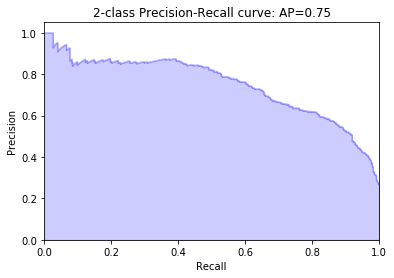

In [42]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test.astype('int'), y_pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

**References:**

[Deep Learning Glossary](http://www.wildml.com/deep-learning-glossary/)

[Keras and NN Tutorial](https://indico.cern.ch/event/506145/contributions/2132944/attachments/1258124/1858154/NNinKeras_MPaganini.pdf)

[Keras Cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf)

Free GPU usage: [Google Colaboratory notebooks](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true) & [Kaggle Kernels](https://www.kaggle.com/kernels).